In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import scipy
import pandas as pd

from IPython import display

In [16]:
nx = 25
ny = 25
k = 1e-1 * 9.87e-13  # 1 darcy to m^2
dx = 3 # m
dy = 3 # m
phi = 0.4
p_0 = 150 * 10 ** 5  # psi to Pa
d = 30  # m
dt = 120  # s
s_0 = 0.3
s_b = 0.1
p = np.ones((nx*ny, 1)) * p_0
s_o = np.ones((nx*ny, 1)) * s_0
s_w = np.ones((nx*ny, 1))* (1 - s_0)

In [17]:
c_w = 1e-6 # # Pa^-1
c_o = 1e-6 # # Pa^-1
c_r = 3e-6 #  Pa^-1 

In [18]:
B_o = 1
B_w = 1
mu_o = 15 / 1000 # cp to Pa * s
mu_w = 1 / 1000 # cp to Pa * s

In [19]:
l_w = 2.
l_o = 2.
s_wir = 0.2
s_wor = 0.8
k_rwr = 0.1
k_rot = 1.
e_w = 1.
e_o = 1.
t_w = 2.
t_o = 2.

In [20]:
1 / (1/ dx + np.pi / d)

2.2828283291679354

In [21]:
from petro_env import Properties

In [22]:
prop = Properties(nx=nx, ny=ny, k=k, dx=dx, dy=dy, phi=phi, p_0=p_0, d=d, dt=dt, s_0=s_0,
                 c_w=c_w, c_o=c_w, c_r=c_r, mu_w=mu_w, mu_o=mu_o, b_o=B_o, b_w=B_w, l_w=l_w, l_o=l_o,
                 s_wir=s_wir, s_wor=s_wor, k_rwr=k_rwr, k_rot=k_rot, e_w=e_w, e_o=e_o, t_w=t_w, t_o=t_o)

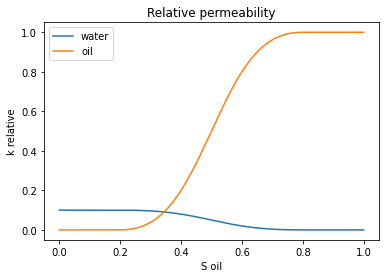

In [23]:
ss = np.linspace(0, 1, 200)
k_rels_w = [prop.k_rel_w(1-s) for s in ss]
k_rels_o = [prop.k_rel_o(s) for s in ss]
plt.plot(ss, k_rels_w, label='water')
plt.plot(ss, k_rels_o, label='oil')
plt.xlabel('S oil')
plt.ylabel("k relative")
plt.title('Relative permeability')
plt.legend()
plt.show()

In [24]:
from petro_env import ResState

In [25]:
p = ResState(p, p_0, prop)
s_o = ResState(s_o, s_b, prop)
s_w = ResState(s_w, 1 - s_b, prop)

In [26]:
pos_r = {(8, 8): 0.1, (18, 21): 0.1}
delta_p_well = -100 * 6894.
delta_p_vec = np.ones((nx*ny, 1)) * delta_p_well

In [27]:
n_iter = int(5e3)
p_ex = np.ones((nx, 1)) * p_0
t = 0
xs = list((np.linspace(0, nx-1, nx) + dx/2) * dx)
plot_freq = int(5)
times = []
p_well_hist = {}
s_o_well_hist = {}
q_o_hist = {}
q_w_hist = {}
for w in pos_r:
    p_well_hist[w] = []
    s_o_well_hist[w] = []
    q_o_hist[w] = []
    q_w_hist[w] = []

In [29]:
from petro_env import PetroEnv
env = PetroEnv(p=p, s_o=s_o, s_w=s_w, prop=prop, pos_r=pos_r, delta_p_well=delta_p_well, max_time=365)

In [30]:
from petro_session import Session as ses

In [31]:
env.reset()
sesion = ses(env, n_iter=int(1e6), plot_freq=100)

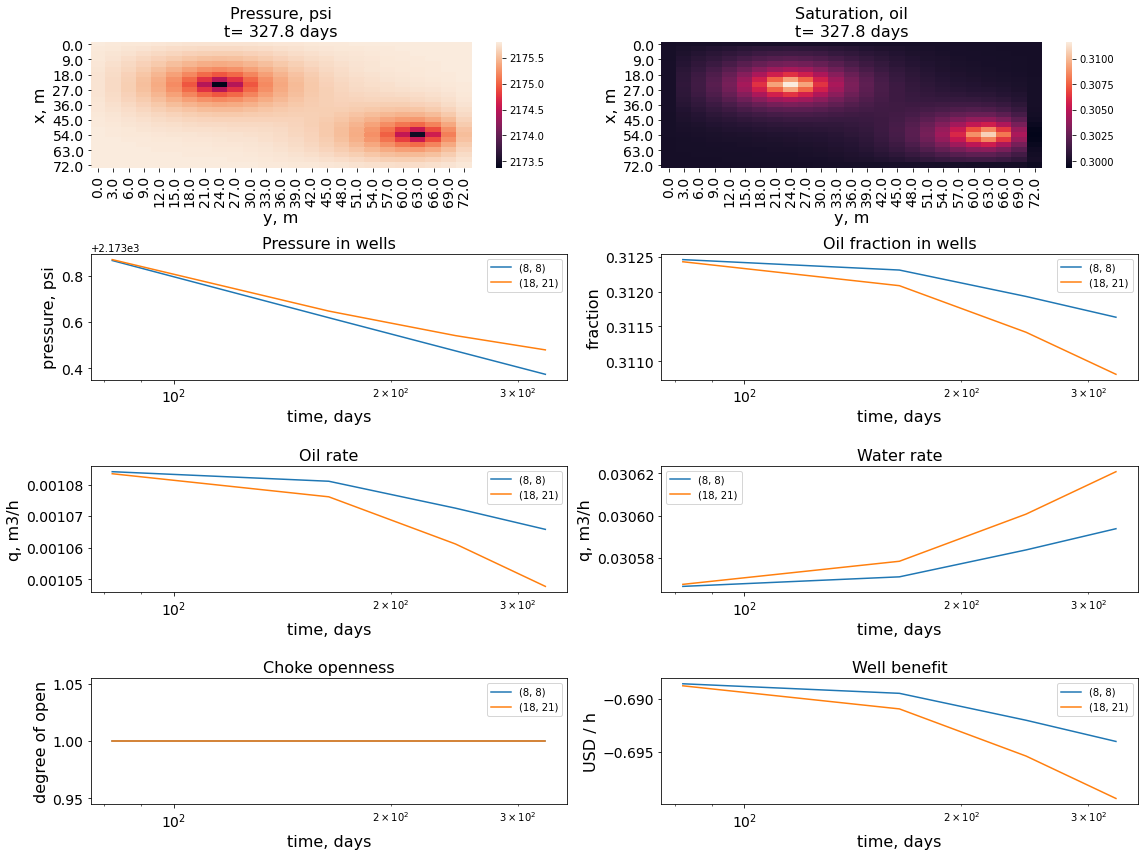

In [32]:
sesion.run()

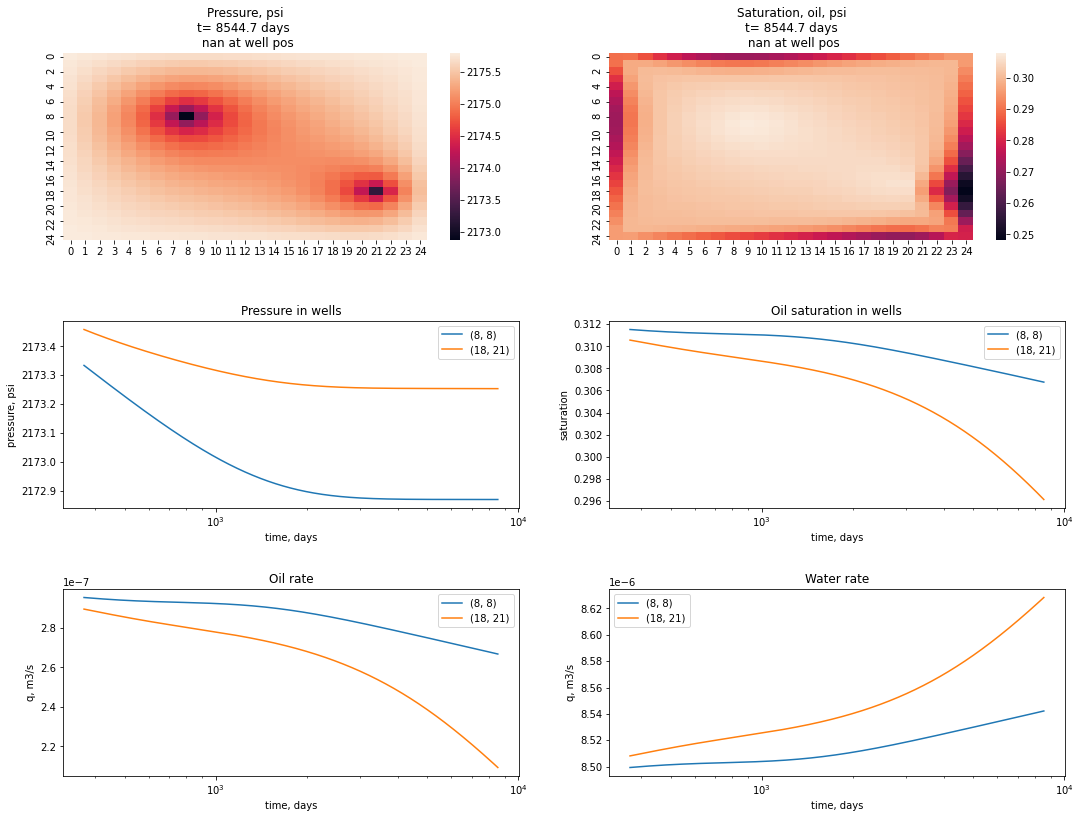

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [58:17<00:00,  1.43it/s]

Wall time: 58min 17s


In [33]:
%%time
for i in tqdm(range(n_iter)):
    # gonna increase time step
    # matrixes depends on saturation
    env.step()
    if i % plot_freq == 0:
        
        q_o = env.get_q(ph='o')
        q_w = env.get_q(ph='w')
        
        # gonna set wells as nan to see gradient
        # p_v_disp = p.v.reshape((nx, ny)).copy() / 6894.
        # s_o_disp = s_o.v.reshape((nx, ny)).copy()
        
        times.append(env.t)
        for w in pos_r:
            p_well_hist[w].append(env.p[w] / 6894.)
            s_o_well_hist[w].append(env.s_o[w])
            q_o_hist[w].append(q_o[w])
            q_w_hist[w].append(q_w[w])
            # set wells as nan to see gradient
            # p_v_disp[w] = np.nan
            # s_o_disp[w] = np.nan
        display.clear_output(wait=True)
        f, ax = plt.subplots(nrows=3, ncols=2, figsize=(16, 12))
        f.tight_layout(pad=6.0)
        
        sns.heatmap(env.p.v.reshape((nx, ny)) / 6894., ax=ax[0][0], cbar=True)
        ax[0][0].set_title(f'Pressure, psi\nt={env.t: .1f} days \n nan at well pos')
        
        sns.heatmap(env.s_o.v.reshape((nx, ny)), ax=ax[0][1], cbar=True, fmt=".2f")
        ax[0][1].set_title(f'Saturation, oil, psi\nt={env.t: .1f} days\n nan at well pos')
        
        for w in pos_r:
            ax[1][0].plot(times, p_well_hist[w] , label=f'{w}')
            ax[1][1].plot(times, s_o_well_hist[w] , label=f'{w}')
            ax[2][0].plot(times, q_o_hist[w] , label=f'{w}')
            ax[2][1].plot(times, q_w_hist[w] , label=f'{w}')
        ax[1][0].set_xlabel('time, days')
        ax[1][0].set_ylabel('pressure, psi')
        ax[1][0].set_title('Pressure in wells')
        ax[1][0].legend()
        
        ax[1][1].set_xlabel('time, days')
        ax[1][1].set_ylabel('saturation')
        ax[1][1].set_title('Oil saturation in wells')
        ax[1][1].legend()
        
        ax[2][0].set_xlabel('time, days')
        ax[2][0].set_ylabel('q, m3/s')
        ax[2][0].set_title('Oil rate')
        ax[2][0].legend()
        
        ax[2][1].set_xlabel('time, days')
        ax[2][1].set_ylabel('q, m3/s')
        ax[2][1].set_title('Water rate')
        ax[2][1].legend()
        
        ax[1][0].set_xscale('log')
        ax[1][1].set_xscale('log')
        ax[2][0].set_xscale('log')
        ax[2][1].set_xscale('log')
                
        plt.show()